<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/5.mutual_information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 31st May, 2023
# Ref: https://www.kaggle.com/code/ryanholbrook/mutual-information
# Data Source: https://www.kaggle.com/datasets/toramky/automobile-dataset

# Introduction #

First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a **feature utility metric**, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect *any* kind of relationship, while correlation only detects *linear* relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:
- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and,
- able to detect any kind of relationship

# Mutual Information and What it Measures #

Mutual information describes relationships in terms of *uncertainty*. The **mutual information** (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Here's an example from the *Ames Housing* data. The figure shows the relationship between the exterior quality of a house and the price it sold for. Each point represents a house.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/X12ARUK.png" width=400, alt="Four categories of ExterQual: Fair, Typical, Good, Excellent. A scatter plot of SalePrice within each category.">
<figcaption style="textalign: center; font-style: italic"><center>Knowing the exterior quality of a house reduces uncertainty about its sale price.
</center></figcaption>
</figure>

From the figure, we can see that knowing the value of `ExterQual` should make you more certain about the corresponding `SalePrice` -- each category of `ExterQual` tends to concentrate `SalePrice` to within a certain range. The mutual information that `ExterQual` has with `SalePrice` is the average reduction of uncertainty in `SalePrice` taken over the four values of `ExterQual`. Since `Fair` occurs less often than `Typical`, for instance, `Fair` gets less weight in the MI score.

(Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.)

# Interpreting Mutual Information Scores #

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

The next figure will give you an idea of how MI values correspond to the kind and degree of association a feature has with the target.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Dt75E1f.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center><strong>Left:</strong> Mutual information increases as the dependence between feature and target becomes tighter. <strong>Right:</strong> Mutual information can capture any kind of association (not just linear, like correlation.)
</center></figcaption>
</figure>
In the figure on the right there are four features. All four features are continuous and vary in a sinusoidal manner with respect to target. The feature that varies most, it has the least MI and the feature that varies linearly has the highest MI. In the left figure on the right, all target values, on an average, increase as feature values increases. But for some features (light brown), variations around mean is large and for some features (dark brown) variation around mean is small. Features with least variations have highest MI.   

Here are some things to remember when applying mutual information:
- MI can help you to understand the *relative potential* of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI *can't detect interactions* between features. It is a **univariate** metric.
- The *actual* usefulness of a feature *depends on the model you use it with*. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.



# Example - 1985 Automobiles



The [*Automobile*](https://www.kaggle.com/toramky/automobile-dataset) dataset consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's `price` (the target) from 23 of the car's features, such as `make`, `body_style`, and `horsepower`. In this example, we'll rank the features with mutual information and investigate the results by data visualization.

This hidden cell imports some libraries and loads the dataset.

In [5]:
# 1.0 Call libraries:

import numpy as np
import pandas as pd

# 1.0.1
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# 1.0.2
import seaborn as sns
from pathlib import Path

In [6]:
# 1.0.3 Matplotlib plotting style:

plt.style.use("seaborn-whitegrid")

<ipython-input-6-2adb1bd3be0d>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [7]:
# 1.0.4 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [4]:
# 1.1 Get data from gdrive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
# 1.2 Where is data?

pathToFolder = "/gdrive/MyDrive/Colab_data_files/automobile"


In [9]:
# 1.2.1 Full file path:

path = Path(pathToFolder) / "automobile_data.csv"

In [10]:
# 2.0 Read data

df = pd.read_csv(path)
df.shape
df.head()

(205, 26)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that *must* have a `float` dtype is *not* discrete. Categoricals (`object` or `categorial` dtype) can be treated as discrete by giving them a label encoding. (You can review label encodings in our [Categorical Variables](http://www.kaggle.com/alexisbcook/categorical-variables) lesson.)

In [11]:
# 2.1 Checking total entries with '?' in each column
# Ref: https://www.kaggle.com/code/umangaggarwal/automobile-price-prediction-with-0-93-r2-score

for col in df.columns:
    if('?' in df[col].values):
        print(col + " = " + str(len(df[df[col]=='?'])))

normalized-losses = 41
num-of-doors = 2
bore = 4
stroke = 4
horsepower = 2
peak-rpm = 2
price = 4


<ipython-input-11-fba85d4dc2e1>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if('?' in df[col].values):




Observations:

    There are 41 '?' in normalized losses column
    Others have 2-4 entries with '?'.

To handle

    We will drop '?' entries of price column & num-of-doors column.
    We will replace '?' with mean value for every other column.



## Handling missing values

Removing '?' and changing data type


In [12]:
# 3.0 Converting price column type to numeric & Dropping '?' entries from price column
# 3.0.1 
df['price'] = df['price'].replace('?',np.nan)
# 3.0.2
df['price'] = pd.to_numeric(df['price'])


In [14]:
# 3.0.3 Get those entries which are not null:
#       That is drop null entries:

df = df[df['price'].notna()]
df.shape   # (201, 26)
df.head()


(201, 26)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950.0
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450.0


In [15]:

# 3.1 Dropping '?' from num-of-doors column 

df['num-of-doors'] = df['num-of-doors'].replace('?',np.nan)

# 3.1.1 Keep only not null entries:
df = df[df['num-of-doors'].notna()]

# 3.1.2
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          199 non-null    int64  
 1   normalized-losses  199 non-null    object 
 2   make               199 non-null    object 
 3   fuel-type          199 non-null    object 
 4   aspiration         199 non-null    object 
 5   num-of-doors       199 non-null    object 
 6   body-style         199 non-null    object 
 7   drive-wheels       199 non-null    object 
 8   engine-location    199 non-null    object 
 9   wheel-base         199 non-null    float64
 10  length             199 non-null    float64
 11  width              199 non-null    float64
 12  height             199 non-null    float64
 13  curb-weight        199 non-null    int64  
 14  engine-type        199 non-null    object 
 15  num-of-cylinders   199 non-null    object 
 16  engine-size        199 non

In [16]:
# 4.0 Converting column type to numeric and replacing '?' with mean value
num_col = ['normalized-losses', 'bore',  'stroke', 'horsepower', 'peak-rpm']


In [17]:
# 4.1
for col in num_col:
    df[col] = df[col].replace('?', np.nan)
    df[col] = pd.to_numeric(df[col])
    df[col].fillna(df[col].mean(), inplace=True)

# 4.0.1    
df.head(10)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,121.840491,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.840491,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.840491,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
5,2,121.840491,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0
6,1,158.000000,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
7,1,121.840491,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,18920.0
8,1,158.000000,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
10,2,192.000000,bmw,gas,std,two,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.80,8.8,101.0,5800.0,23,29,16430.0


## Start analysis:

In [18]:
# 5.0
X = df.copy()
y = X.pop("price")

In [20]:
# 5.1 Label encoding for categoricals
# Refer: https://stackoverflow.com/a/39390208/3282777
#

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [21]:
# 5.2 All discrete features should now have integer
#     dtypes (double-check this before using MI!)

discrete_features = X.dtypes == int

# 5.2.1
discrete_features

symboling             True
normalized-losses    False
make                  True
fuel-type             True
aspiration            True
num-of-doors          True
body-style            True
drive-wheels          True
engine-location       True
wheel-base           False
length               False
width                False
height               False
curb-weight           True
engine-type           True
num-of-cylinders      True
engine-size           True
fuel-system           True
bore                 False
stroke               False
compression-ratio    False
horsepower           False
peak-rpm             False
city-mpg              True
highway-mpg           True
dtype: bool

Scikit-learn has two mutual information metrics in its `feature_selection` module: one for real-valued targets (`mutual_info_regression`) and one for categorical targets (`mutual_info_classif`). Our target, `price`, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [23]:
# 6.0
def make_mi_scores(X, y, discrete_features):
    # 6.0.1 Get sores
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    # 6.0.2 Transform mi_scores to a Series:
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    # 6.0.3 Sort Series in Descending order:
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores



In [24]:
# 6.1 Execute the function now:

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb-weight          1.475167
horsepower           0.874344
wheel-base           0.585718
fuel-system          0.483483
stroke               0.356791
symboling            0.234097
compression-ratio    0.174718
body-style           0.077359
num-of-doors         0.003503
Name: MI Scores, dtype: float64

And now a bar plot to make comparisions easier:

In [26]:
# 7.0 Plot function:

def plot_mi_scores(scores):
    # Scores sorted in ascending order:
    scores = scores.sort_values(ascending=True)
    # Map parameters:
    width = np.arange(len(scores))
    # Write ticks as per scores index:
    ticks = list(scores.index)
    # Plot width:
    plt.barh(width, scores)
    # Plot yticks
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


<Figure size 800x500 with 0 Axes>

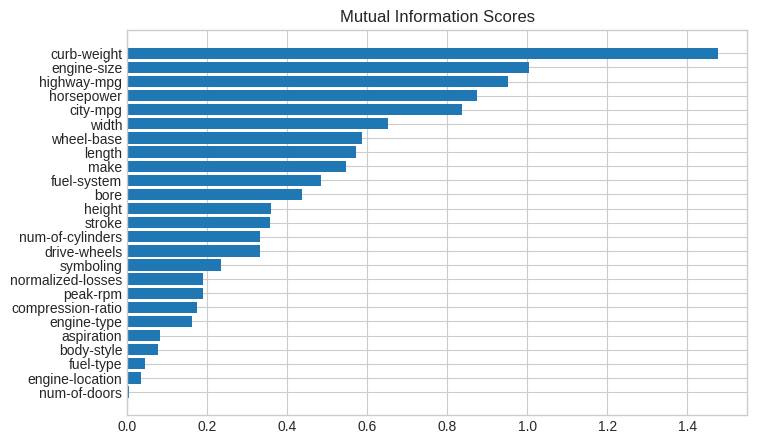

In [28]:
# 7.1
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring `curb_weight` feature exhibits a strong relationship with `price`, the target.


In [30]:
# 8.0
X.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg'],
      dtype='object')

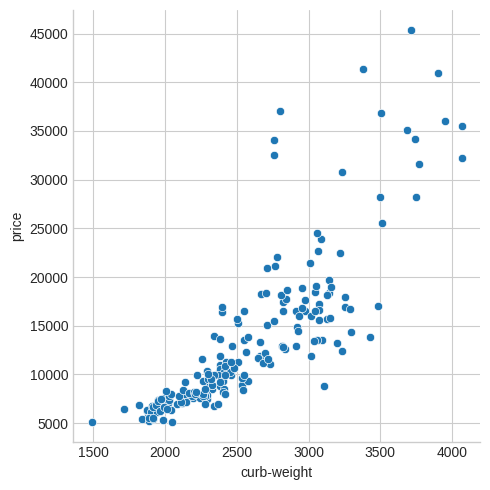

In [31]:
# 8.1
sns.relplot(x="curb-weight", y=y, data=X);

The `fuel_type` feature has a fairly low MI score, but as we can see from the figure, it clearly separates two `price` populations with different trends within the `horsepower` feature. This indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

In [32]:
# 8.2
X['price'] = y

In [33]:
# 8.2.1
X.dtypes

symboling              int64
normalized-losses    float64
make                   int64
fuel-type              int64
aspiration             int64
num-of-doors           int64
body-style             int64
drive-wheels           int64
engine-location        int64
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type            int64
num-of-cylinders       int64
engine-size            int64
fuel-system            int64
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

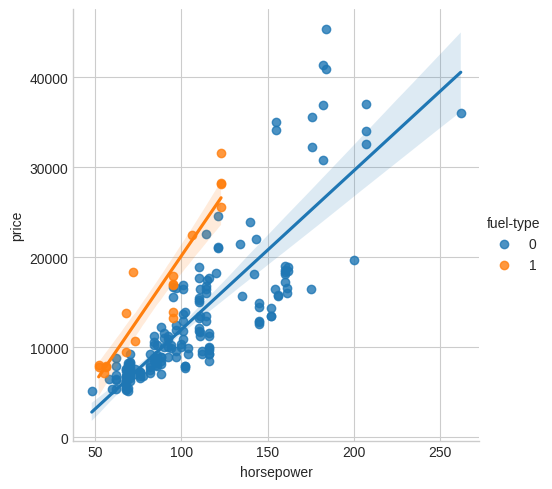

In [34]:
# 8.3
sns.lmplot(x="horsepower", y= "price", hue="fuel-type", data= X);

Data visualization is a great addition to your feature-engineering toolbox. Along with utility metrics like mutual information, visualizations like these can help you discover important relationships in your data. Check out our [Data Visualization](https://www.kaggle.com/learn/data-visualization) course to learn more!



# Comparison of F-test and mutual information
See [here](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#comparison-of-f-test-and-mutual-information)

This example illustrates the differences between univariate F-test statistics and mutual information.

We consider 3 features x_1, x_2, x_3 distributed uniformly over [0, 1], the target depends on them as follows:

y = x_1 + sin(6 * pi * x_2) + 0.1 * N(0, 1), that is the third features is completely irrelevant.

The code below plots the dependency of y against individual x_i and normalized values of univariate F-tests statistics and mutual information.

As F-test captures only linear dependency, it rates x_1 as the most discriminative feature. On the other hand, mutual information can capture any kind of dependency between variables and it rates x_2 as the most discriminative feature, which probably agrees better with our intuitive perception for this example. Both methods correctly marks x_3 as irrelevant.

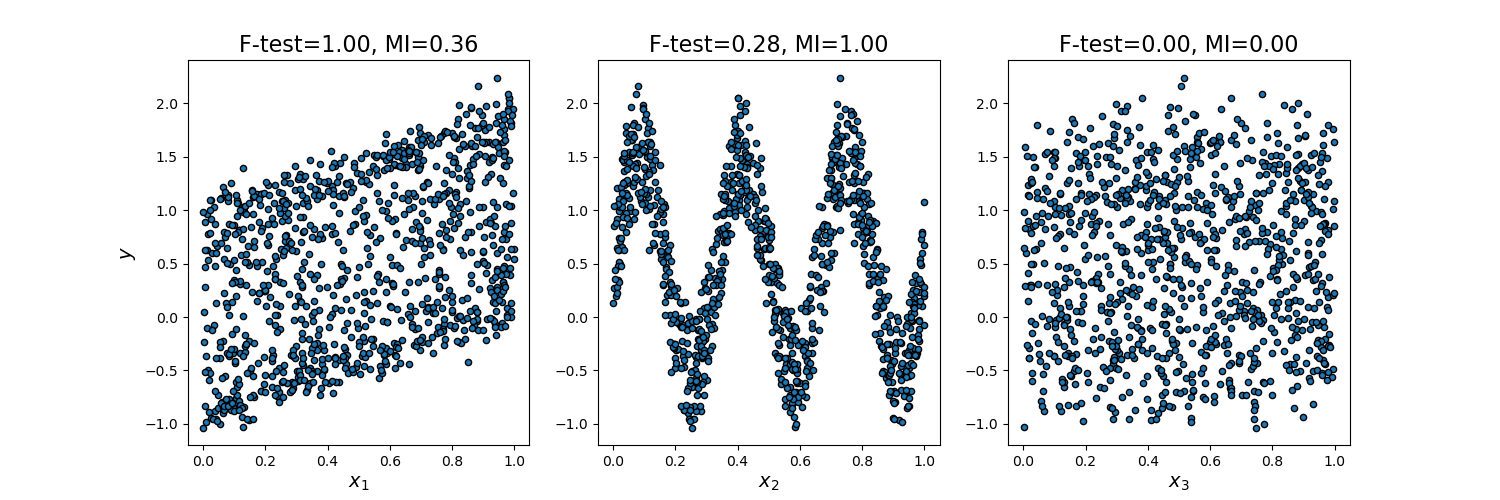

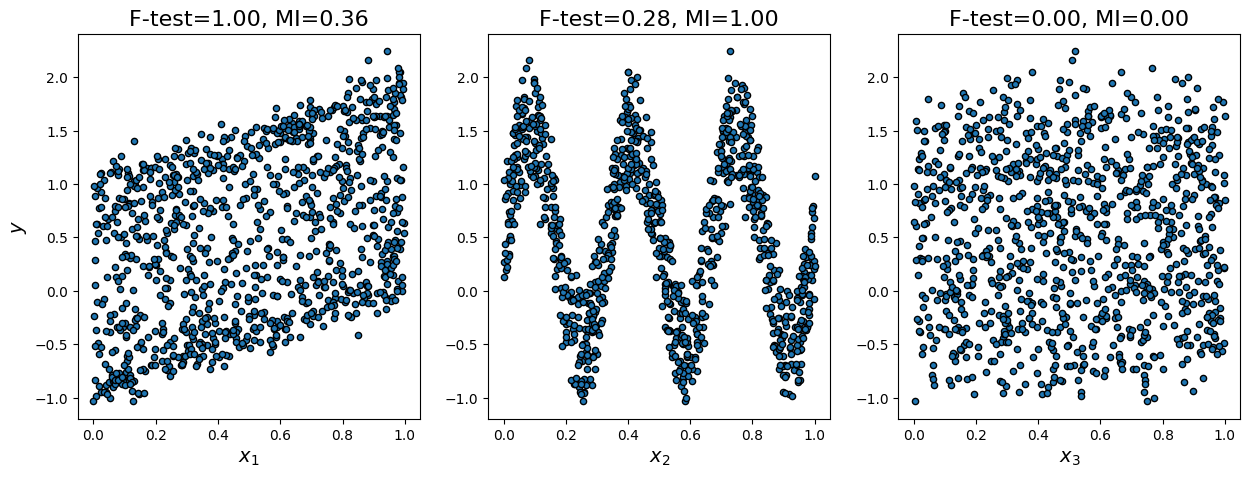

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor="black", s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]), fontsize=16)
plt.show()

# Your Turn #

Run this exercise for dataset at [this link](https://huggingface.co/datasets/scikit-learn/student-alcohol-consumption).